# RNN,  LSTM vizual plot

In [1]:
!pip install Keras
!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.fftpack import fft
from scipy import signal
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import io
import pandas as pd
import numpy as np
import matplotlib  as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler 

In [2]:
%matplotlib inline
dfx=pd.read_csv('data_zero.csv')
calculation_speed = 100
dfx[::calculation_speed]

,miliseka,P20113,P20110,P10216,P10215,P10116,P10115,P10110,P7500
0,1.366789e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100,1.366789e+12,-0.016565,-0.021564,0.003126,0.006878,-0.014059,-0.012186,-0.004062,-0.005625
200,1.366789e+12,-0.001566,-0.009378,-0.001251,0.003441,-0.012184,-0.012814,0.000937,0.006875
300,1.366789e+12,0.008438,0.003124,0.000313,0.004377,-0.009686,-0.010000,-0.002812,-0.003125
400,1.366789e+12,0.013123,0.007496,-0.010313,-0.009060,-0.005938,-0.005001,0.001875,0.008125
...,...,...,...,...,...,...,...,...,...
119500,1.366791e+12,-0.001251,-0.000629,0.020937,0.020939,0.002502,0.006876,-0.003437,-0.003437
119600,1.366791e+12,0.003437,0.001873,0.009375,0.010941,0.005314,0.009686,0.002187,0.002188
119700,1.366791e+12,0.040312,0.039684,0.021563,0.025003,0.008125,0.005314,0.002188,0.001875
119800,1.366791e+12,0.030622,0.023746,0.021875,0.025002,0.005938,0.006561,0.008750,0.006562


In [3]:
# **Why is do we have 3 values as inputs?**

# We will see latter that RNNs, LTSMs require 3D input for the X values. This is often very confusing for beginners and people who return back to the field after a break (make sure you remember this, because even if you are an employeed data scientist you might not work with RNNs and forget this information, which is fundamental to understanding of RNNs). What are those 3 dimensions:

# - **Samples / how many sequences**. One sequence is one sample. A batch is comprised of one or more samples (batch size not specified).
# - **Time Steps / how many values in each sample**. One time step is one point of observation in the sample.
# - **Features / collumn count**. One feature is one observation at a time step. This is essentially how many values at each time step you have.

# Say we want to feed this into our network:

In [4]:
def taking_of_nan_values_DF(df):
    print("taking_of_nan_values_DF(df)")
    # interpolation
    df = df.interpolate(method='linear', limit_direction='forward', axis=0)
    # taking of nullmi
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

In [5]:
df = pd.DataFrame(dfx[::calculation_speed])
df = taking_of_nan_values_DF(pd.DataFrame(df))
df

taking_of_nan_values_DF(df)


,miliseka,P20113,P20110,P10216,P10215,P10116,P10115,P10110,P7500
0,1.366789e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100,1.366789e+12,-0.016565,-0.021564,0.003126,0.006878,-0.014059,-0.012186,-0.004062,-0.005625
200,1.366789e+12,-0.001566,-0.009378,-0.001251,0.003441,-0.012184,-0.012814,0.000937,0.006875
300,1.366789e+12,0.008438,0.003124,0.000313,0.004377,-0.009686,-0.010000,-0.002812,-0.003125
400,1.366789e+12,0.013123,0.007496,-0.010313,-0.009060,-0.005938,-0.005001,0.001875,0.008125
...,...,...,...,...,...,...,...,...,...
119500,1.366791e+12,-0.001251,-0.000629,0.020937,0.020939,0.002502,0.006876,-0.003437,-0.003437
119600,1.366791e+12,0.003437,0.001873,0.009375,0.010941,0.005314,0.009686,0.002187,0.002188
119700,1.366791e+12,0.040312,0.039684,0.021563,0.025003,0.008125,0.005314,0.002188,0.001875
119800,1.366791e+12,0.030622,0.023746,0.021875,0.025002,0.005938,0.006561,0.008750,0.006562


In [6]:
def plot_learning_curves(loss):
    print("plot_learning_curves(loss)")
    plt.figure(figsize=(14,5))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)  


In [7]:
def RNN2(new_dataset, valid_data, interval_to_train, column, scaler, lstm_model, parameter):      
    # construct the dataset for prediction
    inputs_data=new_dataset[len(new_dataset)-len(valid_data)-parameter:].values
    inputs_data=inputs_data.reshape(-1,1)
    inputs_data=scaler.transform(inputs_data)
    X_test=[]
    for i in range(parameter,inputs_data.shape[0]):
        X_test.append(inputs_data[i-parameter:i,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

    predicted_closing_price=lstm_model.predict(X_test)
#     print(predicted_closing_price)
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
#     print(predicted_closing_price)

    train_data=new_dataset[:interval_to_train]
    valid_data=new_dataset[interval_to_train:]
    valid_data = valid_data.assign(Predictions=predicted_closing_price)
    plt.figure(figsize=(14,5))
    plt.plot(new_dataset[str(column)])    
    plt.title('RNN LSTM ' + str(column), size=12)
    plt.plot(valid_data.index, predicted_closing_price)
    plt.show()
    # Calculate the MSE for predictions
    from sklearn.metrics import mean_squared_error
    mean_squared_error(valid_data[str(column)],predicted_closing_price) 
   # Increase the epoch count and retrain the network, see if MSE improves

In [8]:
def RNN(df):
    columns = df.columns
    print("Starting RNN(df)")
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]], unit='ms')
    import datetime    
    rows = len(df)
    # parameters
    parameter = 10
    number_of_epochs = 10
    number_of_batch_size = 10
    interval_to_train = int(rows/2)

    columns = df.columns
    for column in columns:
        if column != df.columns[0]:

            print(column)
            df['Date'] = df[df.columns[0]]
            # Timestamp('2017-03-22 15:16:45.433502912')
            df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
            df.index=df['Date']
            
            data=df.sort_index(ascending=True,axis=0)
            new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date',str(column)])

            for i in range(0,len(data)):
                new_dataset["Date"][i]=data['Date'][i]
                new_dataset[str(column)][i]=data[str(column)][i]

            train_data = new_dataset[0:interval_to_train]
            valid_data = new_dataset[interval_to_train:]

            new_dataset.index=new_dataset.Date
            new_dataset.drop("Date",axis=1,inplace=True)

            new_dataset.tail(5)

            scaler=MinMaxScaler(feature_range=(0,1))
            scaled_data=scaler.fit_transform(new_dataset)

            # construct the sequences: we will try to predict y
            # ... based on last parameter values of x
            x_train_data, y_train_data=[],[]
            for i in range(parameter,len(train_data)):
                x_train_data.append(scaled_data[i-parameter:i,0])
                y_train_data.append(scaled_data[i,0])

            # convert to numpy
            x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
            print(x_train_data.shape)

            # reshape it to 3D
            x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

            # to see how the shape changes we can again print it out
            lstm_model=Sequential()
            lstm_model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data.shape[1],1)))
            lstm_model.add(LSTM(units=50))
            lstm_model.add(Dense(1))
            lstm_model.compile(loss='mean_squared_error',optimizer='adam')
            
            history = lstm_model.fit(x_train_data,y_train_data, epochs=number_of_epochs, batch_size=number_of_batch_size,verbose=1)
            
            plot_learning_curves(history.history["loss"])
            plt.show()
            
            RNN2(new_dataset, valid_data, interval_to_train, column, scaler, lstm_model, parameter)
          
           # Increase the epoch count and retrain the network, see if MSE improves


Starting RNN(df)
P20113
(590, 10)
Epoch 1/10
59/59 [==============================] - 2s 4ms/step - loss: 0.0807
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 6/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 8/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 9/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 10/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0107
plot_learning_curves(loss)


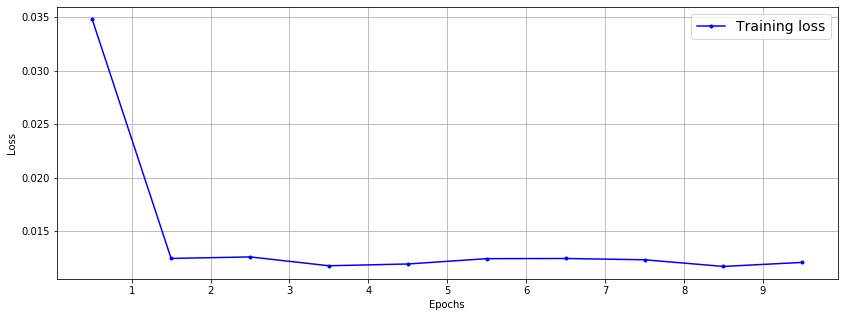

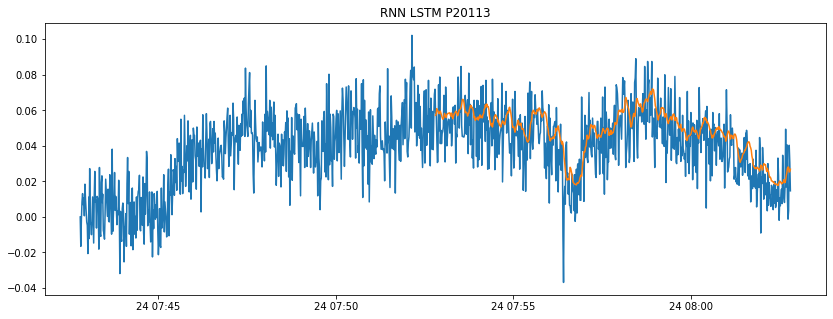

P20110
(590, 10)
Epoch 1/10
59/59 [==============================] - 2s 3ms/step - loss: 0.0842
Epoch 2/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 4/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 5/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 7/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 9/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 10/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0123
plot_learning_curves(loss)


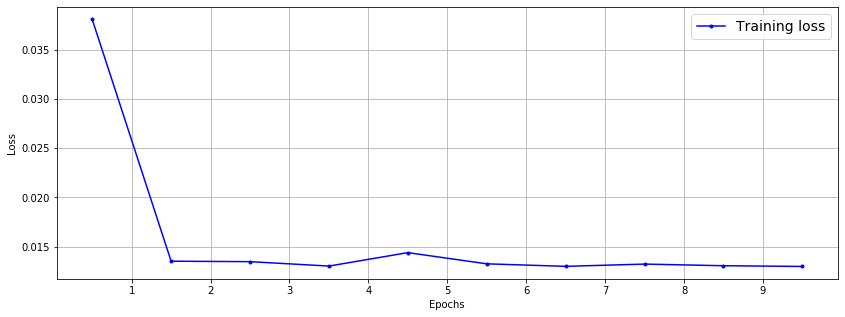

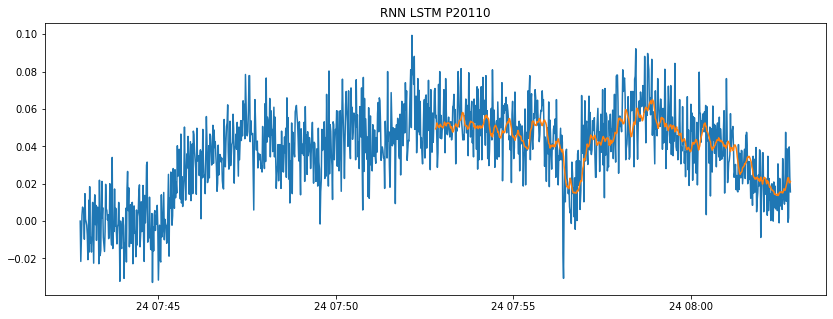

P10216
(590, 10)
Epoch 1/10
59/59 [==============================] - 2s 4ms/step - loss: 0.1704
Epoch 2/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 3/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 8/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 9/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 10/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0027
plot_learning_curves(loss)


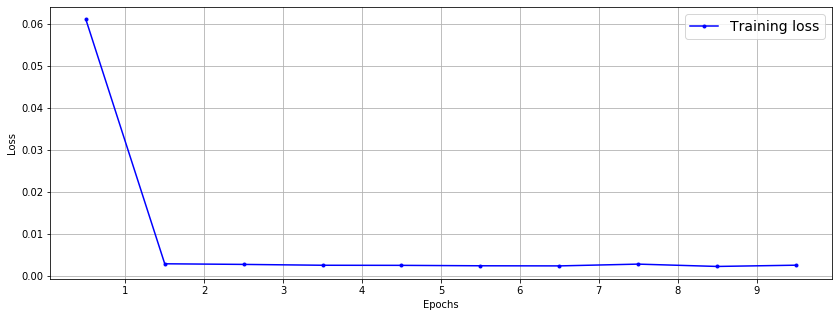

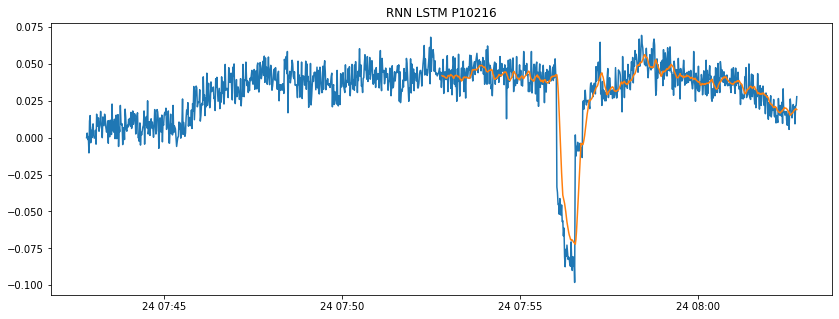

P10215
(590, 10)
Epoch 1/10
59/59 [==============================] - 2s 3ms/step - loss: 0.1660
Epoch 2/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 3/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 5/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 7/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 8/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 9/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0014
plot_learning_curves(loss)


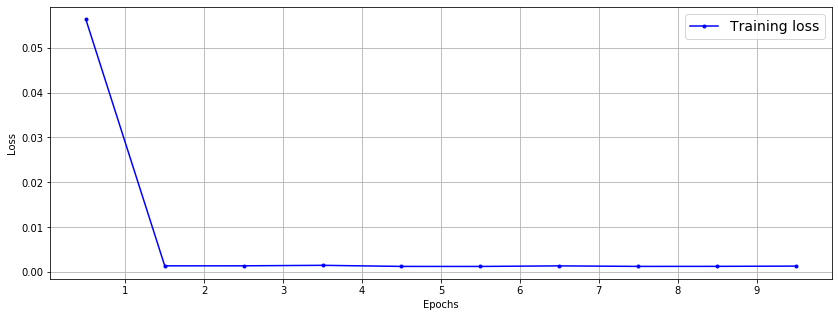

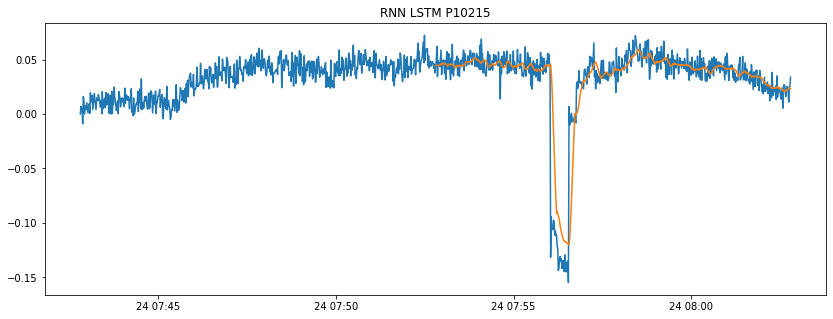

P10116
(590, 10)
Epoch 1/10
59/59 [==============================] - 2s 4ms/step - loss: 0.2423
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 6/10
59/59 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 8/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 9/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 10/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0022
plot_learning_curves(loss)


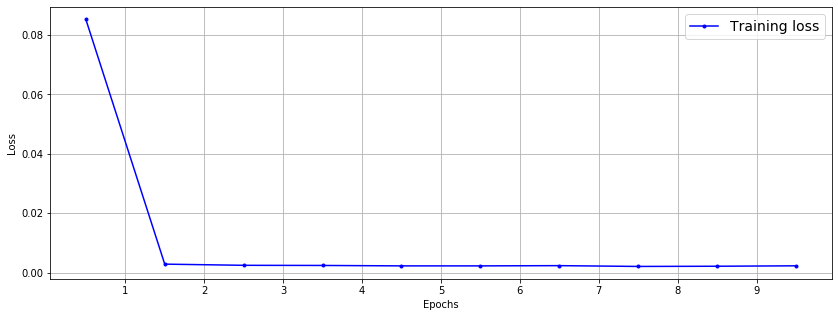

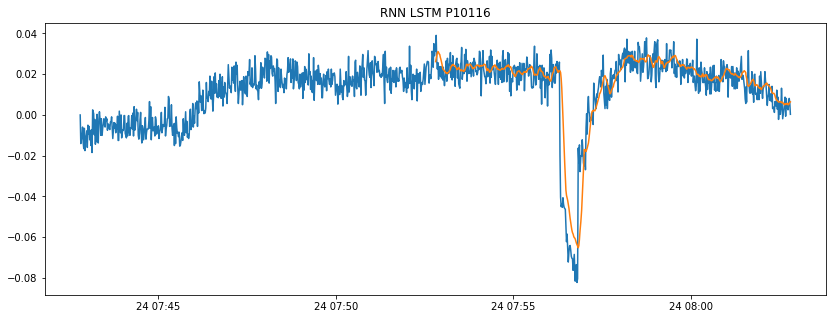

P10115
(590, 10)
Epoch 1/10
59/59 [==============================] - 2s 4ms/step - loss: 0.1159
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 4/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 5/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 6/10
59/59 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 8/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 9/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 10/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0021
plot_learning_curves(loss)


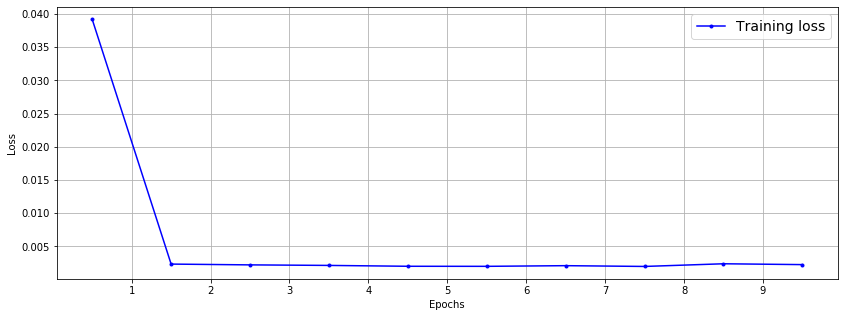

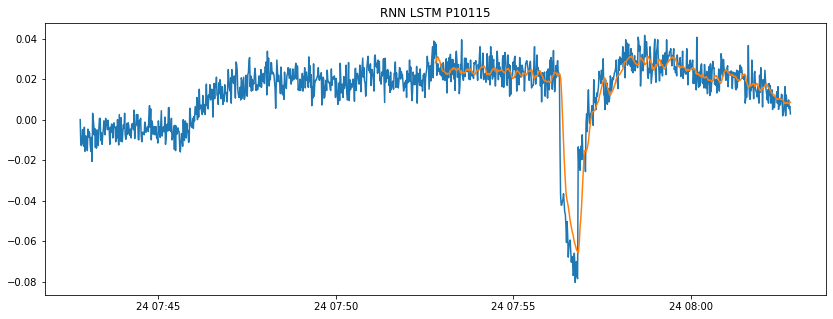

P10110
(590, 10)
Epoch 1/10
59/59 [==============================] - 2s 4ms/step - loss: 0.0707
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 8/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 9/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 10/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0061
plot_learning_curves(loss)


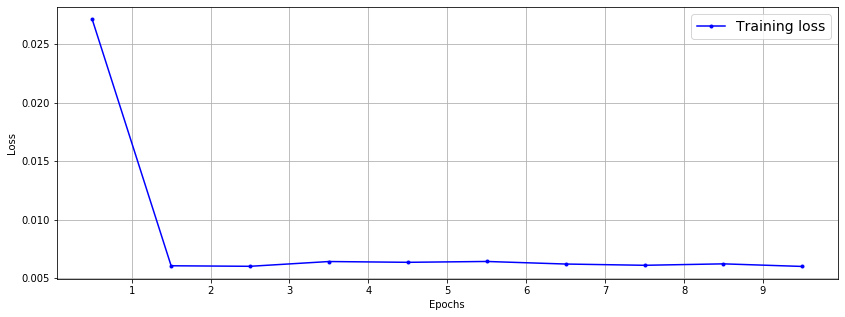

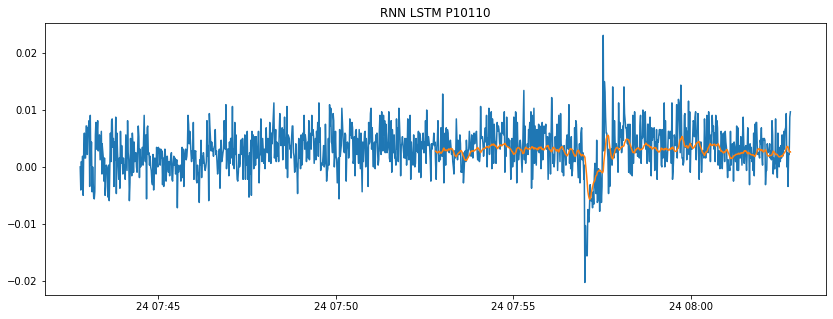

P7500
(590, 10)
Epoch 1/10
59/59 [==============================] - 2s 4ms/step - loss: 0.0757
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 8/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 9/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 10/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0050
plot_learning_curves(loss)


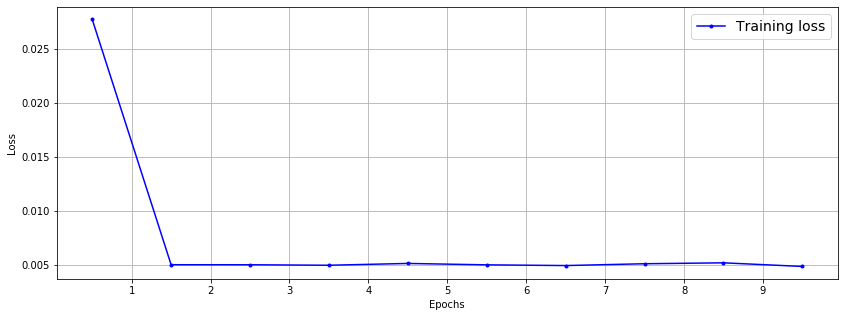

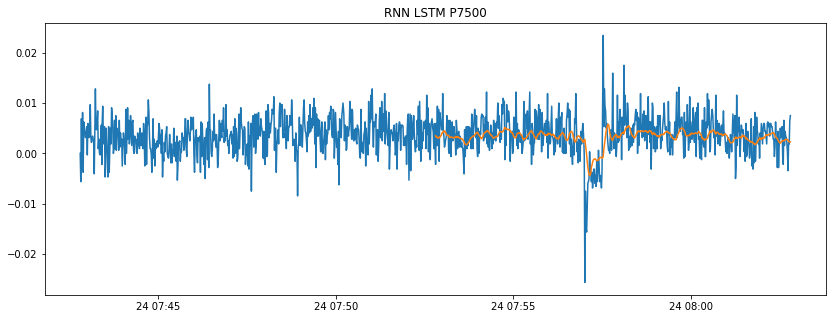

In [9]:
RNN(df)